<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>


### Calculating Error from Spatial Datasets with Disparate Accuracy and Scale

#### Blazej Ksiazek, Graduate Research Assistant, University of Texas at Austin 

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

#### Hildebrand Department of Petroleum and Geosystems Engineering, The University of Texas at Austin

#### Department of Geological Sciences, The University of Texas at Austin

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)


## Executive Summary

We demonstrate a workflow to quantify uncertainty for spatial models while robustly accounting for spatial continuity defined by semivariogram models and scale with dispersion variance for the common case of two data sets, one with greater accuracy, smaller scale, but poor coverage, sparsely sampled, and another dataset with exhaustive coverage but with lower accuracy, larger scale.

#### Spatial Volume-variance

Variance is dependent on scale or the volume support of the measurement or model. 

* as volume support increases, variance decreases

Dispersion variance is a general form of variance that account for the scale and spatial continuity.

* for a demonstration of the impact on variance of volume support see this Python [volume-variance demonstration](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/GeostatsPy_volume_variance.ipynb) or this simple dmeonstration in Excel [volume-variance demonstration](https://github.com/GeostatsGuy/ExcelNumericalDemos/blob/master/Volume_Variance.xlsx).

* the dispersion variance is the variance integrated over a a larger volume, $V$, at the scale of smaller volume, $v$. 

\begin{equation}
D^2(v,V) = \frac{1}{V} \int_{V(\bf{u})}  E {[Z_V(\bf{u}) - Z_v(\bf{y})]^2}dy = \frac{1}{V} \int_{V(\bf{u})} \sigma_{E}^2 (V(\bf{u}),v(\bf{u}))dy
\end{equation}

* the dispersion variance may be calculated with volume integrated variograms, known as gamma bar, \overline{\gamma}}$, values.

* gammabar values are calculated as:

\begin{equation}
\overline{\gamma}(V,v) = \frac{1}{V \cdot v} \int_{V(\bf{u})} \int_{v(\bf{u^{\prime}})} \gamma(y-y^{\prime}) dy^{\prime} dy
\end{equation}

where the variogram at data support is integrated over the larger valume, $V$, by the head of the lag vector, $V(\bf{u})$, and the smaller volume, $v(\bf{u^{\prime}})$, by the tail of the lag vector, $\bf{u^{\prime}}$.

In practice this is calulated by discritizing the two volumes, $V$ and $v$. We will work with numerical integration over the scale of core data.

#### Problem Setting

To demonstrate a practical application of volume-variance relations let's solve the following problem. 

We need to calculate the error in variance due to the use of well logs instead of core data to infer porosity.The well log data is our larger volume support data, $V$, and the core data is our smaller volume support data, $v$.

* core measured porosity is more accurate than well log infered porosity

* well logs are at a larger scale than core measurements

We start with the difference calculated at collocated locations in the subsurface, known as the residual (r). 

\begin{equation}
x_r(\bf{u_\alpha}) = x_V(\bf{u_\alpha}) - x_v(\bf{u_\alpha}),  \alpha=1,2,...,n 
\end{equation}

The residual variance is calculated over all locations with collocated $v$ and $V$ data as:

\begin{equation}
\sigma_{x_r}^2 = \frac{1}{n}\sum_{\alpha=1}^{n} (x_r(u_\alpha) - \overline{x_r(u_\alpha}) 
\end{equation}


The residual variance is a combination of:

1. **core-log error** - assumed to be random error at the scale of the core data, $\sigma_{x_r,error}^2$
2. **scale change** - regression to the mean due to scale change. We can decompose, calculate the components with volume variance, $\sigma_{x_r,scale}^2$

If both sources of uncertainty are uncorrelated, and given the assumption of error free $v$ data we assume additivity of variance, such that: 

\begin{equation}
\sigma_{x_r}^2 = \sigma_{x_r,scale}^2 + \sigma_{x_r,error}^2 
\end{equation}

* for a demonstration of the additivity of variance see this Python [Additivity of Mean and Variance](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/PythonDataBasics_Additvitiy_Variance.ipynb)


We will build a synthetic truth dataset so we can:

* demonstrate the calculations without the complexity related to inference and interpretation 

#### Load the required libraries

The following code loads the required libraries.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats
import math
import copy
import statistics as stats
from scipy.interpolate import BSpline, make_interp_spline
seed = 73074; np.random.seed(seed = seed); nbin = 50

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

* you will need to make sure that the Fortran executable sgsim.exe is in this folder. 
* you can get the GSLIB excutables from [GSLIB.com](http://gslib.com/)

In [2]:
#os.chdir(r'C:\PGE383')

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

We need geostatistical simulation to make the synthetic example and gammabar by numerical integration. We will call the GSLIB fortran executable from the current directory. cova2 is a variogram calculation routine. gammabar and cova2 are reimplimented from the original GSLIB in Fortran.

* you will require the sgsim.exe executable from [GSLIB](http://www.gslib.com/)

In [3]:
def sgsim(nreal,df,xcol,ycol,vcol,tmin,tmax,iref,dfref,cref,
          nx,xmin,xzis,ny,ymin,ysiz,seed,var,ktype,corr,
          sec_map,
          output_file):

    x = df[xcol]
    y = df[ycol]
    v = df[vcol]
    var_min = tmin
    var_max = tmax
    df_temp = pd.DataFrame({"X": x, "Y": y, "Var": v})
    GSLIB.Dataframe2GSLIB("data_temp.dat", df_temp)
    
    if iref == 1:
        var_min = np.min(dfref.iloc[:,cref].values)
        var_max = np.max(dfref.iloc[:,cref].values)
        ref_values = dfref.iloc[:,cref].values
        df_ref_temp = pd.DataFrame({"Ref": ref_values})
        GSLIB.Dataframe2GSLIB("ref_temp.dat", df_ref_temp)
        
    if ktype == 2 or ktype == 4:
        GSLIB.ndarray2GSLIB(sec_map, 'sec_temp.dat', 'sec')

    nug = var["nug"]
    nst = var["nst"]
    it1 = var["it1"]
    cc1 = var["cc1"]
    azi1 = var["azi1"]
    hmaj1 = var["hmaj1"]
    hmin1 = var["hmin1"]
    it2 = var["it2"]
    cc2 = var["cc2"]
    azi2 = var["azi2"]
    hmaj2 = var["hmaj2"]
    hmin2 = var["hmin2"]
    max_range = max(hmaj1, hmaj2)
    min_size = min(xsiz, ysiz)
    hctab = int(max_range / min_size) * 2 + 1

    with open("sgsim.par", "w") as f:
        f.write("              Parameters for SGSIM                                         \n")
        f.write("              ********************                                         \n")
        f.write("                                                                           \n")
        f.write("START OF PARAMETER:                                                        \n")
        f.write("data_temp.dat                 -file with data                              \n")
        f.write("1  2  0  3  0  0              -  columns for X,Y,Z,vr,wt,sec.var.          \n")
        f.write("-1.0e21 1.0e21                -  trimming limits                           \n")
        f.write("1                             -transform the data (0=no, 1=yes)            \n")
        f.write("none.trn                      -  file for output trans table               \n")
        f.write(str(iref) + "                             -  consider ref. dist (0=no, 1=yes)          \n")
        f.write("ref_temp.dat                      -  file with ref. dist distribution          \n")
        f.write(str(1) + " 0                          -  columns for vr and wt                     \n")
        f.write(str(var_min) + " " + str(var_max) + "   zmin,zmax(tail extrapolation)       \n")
        f.write("1   " + str(var_min) + "      -  lower tail option, parameter              \n")
        f.write("1   " + str(var_max) + "      -  upper tail option, parameter              \n")
        f.write("0                             -debugging level: 0,1,2,3                    \n")
        f.write("nonw.dbg                      -file for debugging output                   \n")
        f.write(str(output_file) + "           -file for simulation output                  \n")
        f.write(str(nreal) + "                 -number of realizations to generate          \n")
        f.write(str(nx) + " " + str(xmn) + " " + str(xsiz) + "                              \n")
        f.write(str(ny) + " " + str(ymn) + " " + str(ysiz) + "                              \n")
        f.write("1 0.0 1.0                     - nz zmn zsiz                                \n")
        f.write(str(seed) + "                  -random number seed                          \n")
        f.write("0     8                       -min and max original data for sim           \n")
        f.write("12                            -number of simulated nodes to use            \n")
        f.write("0                             -assign data to nodes (0=no, 1=yes)          \n")
        f.write("1     3                       -multiple grid search (0=no, 1=yes),num      \n")
        f.write("0                             -maximum data per octant (0=not used)        \n")
        f.write(str(max_range) + " " + str(max_range) + " 1.0 -maximum search  (hmax,hmin,vert) \n")
        f.write(str(azi1) + "   0.0   0.0       -angles for search ellipsoid                 \n")
        f.write(str(hctab) + " " + str(hctab) + " 1 -size of covariance lookup table        \n")
        f.write(str(ktype) + " " + str(corr) + " 1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC        \n")
        f.write("sec_temp.dat                      -  file with LVM, EXDR, or COLC variable     \n")
        f.write("1                             -  column for secondary variable             \n")
        f.write(str(nst) + " " + str(nug) + "  -nst, nugget effect                          \n")
        f.write(str(it1) + " " + str(cc1) + " " + str(azi1) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
        f.write(" " + str(hmaj1) + " " + str(hmin1) + " 1.0 - a_hmax, a_hmin, a_vert        \n")
        f.write(str(it2) + " " + str(cc2) + " " + str(azi2) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
        f.write(" " + str(hmaj2) + " " + str(hmin2) + " 1.0 - a_hmax, a_hmin, a_vert        \n")

    os.system("sgsim.exe sgsim.par")
    sim_array = GSLIB.GSLIB2ndarray(output_file, 0, nx, ny)
    return sim_array[0]

def scale_model(core, log_scale, log_error_std):
    if (int(log_scale/xsiz) % 2) == 0:                           # force odd discrete window size
        window = int(log_scale/xsiz) + 1
    else:
        window = int(log_scale/xsiz)

    log = np.zeros(nx)
    log_err = np.zeros(nx)

    nwin = int((window - 1)/2)
    for ix in range(0,nx):
        vsum = 0.0; vsum_err = 0.0; count = 0.0
        for i in range(-1*nwin,nwin):
            if ix+i >= 0 and ix+i < nx:
                vsum = vsum + core[ix+i]
                count = count + 1
        log[ix] = vsum / count

    log_err = log + np.random.normal(loc=0.0,scale=log_error_std,size=nx)
        
    res = log - core
    res_err = log_err - core
        
    df = pd.DataFrame({'X':np.arange(Xmin,Xmax,xsiz),'core':core,'log':log,'res':res,
                  'log_err':log_err,'res_err':res_err,})
    return df

def plot_models(df):
    plt.subplot(121)
    plt.plot(df['X'],df['core'],c='red',alpha=0.2,label='core')
    plt.plot(df['X'],df['log'],c='blue',alpha=0.2,label='log')
    plt.legend(loc='upper right')
    plt.ylabel('Porosity (%)'); plt.xlabel('Depth (m)'); plt.title('Synthetic Wells without Error')
    plt.xlim([0,500]) 

    plt.subplot(122)
    plt.plot(df['X'],df['core'],c='red',alpha=0.2,label='core')
    plt.plot(df['X'],df['log_err'],c='blue',alpha=0.2,label='log')
    plt.legend(loc='upper right')
    plt.ylabel('Porosity (%)'); plt.xlabel('Depth (m)'); plt.title('Synthetic Wells with Error')
    plt.xlim([0,500])

    plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)
    plt.show()

def output_summary(df):
    check = np.round(np.var(df['log'].values) + np.var(df['res'].values) - 2*np.cov(df['log'].values,df['res'].values)[1,0],2) 
    check_err = np.round(np.var(df['log_err'].values) + np.var(df['res_err'].values) - 2*np.cov(df['log_err'].values,df['res_err'].values)[1,0],2) 
    
    print('\nResults')
    print('No Error Variance:')
    print('Core: ' + str(np.round(np.var(df['core'].values),2)) + ', Resid: ' + str(np.round(np.var(df['res'].values),2)) + 
         ', Log: ' + str(np.round(np.var(df['log'].values),2)) + ' Cov: ' + str(np.round(np.cov(df['log'].values,df['res'].values)[1,0],2)) + 
         ', Var Core Calc = ' + str(check) + '.')
    
    print('\nError Variance:')
    print('Core: ' + str(np.round(np.var(df['core'].values),2)) + ', Resid: ' + str(np.round(np.var(df['res_err'].values),2)) + 
         ', Log: ' + str(np.round(np.var(df['log_err'].values),2)) + ' Cov: ' + str(np.round(np.cov(df['log_err'].values,df['res_err'].values)[1,0],2)) + 
         ', Var Core Calc = ' + str(check_err) + '.')
    
    error = np.var(df['res_err'].values) - np.var(df['res'].values)
    
    print('\nVariance Components: ')
    print('Error = ' + str(np.round(error)))
    print('Change in Scale = ' + str(np.round(np.var(df['res'].values),2)))

def variance_proportions(df):
    error = np.var(df['res_err'].values) - np.var(df['res'].values)
    scale = np.round(np.var(df['res'].values),2)
    perror = error/(error+scale)
    pscale = scale/(error+scale)
    return pscale, perror, scale, error
    
def calc_nugget(df):
    # calculate the nugget effect
    core = df['core'].values; log = df['log'].values; log_err = df['log_err'].values
    vario = 0.0; vario_log = 0.0; vario_log_err = 0.0
    for ix in range(0,nx-1):
        vario = vario + (core[ix+1] - core[ix])**2.0
        vario_log = vario_log + (log[ix+1] - log[ix])**2.0
        vario_log_err = vario_log_err + (log_err[ix+1] - log_err[ix])**2.0
    vario = vario/(2*(nx-1))
    vario_log = vario_log/(2*(nx-1))
    vario_log_err = vario_log_err/(2*(nx-1))
    
    print('\nVariogram Analysis, Nugget Effect:')
    print('Core = ' + str(np.round(vario,2)) + ', Log = ' + str(np.round(vario_log,2)) + ', Log With Error = ' + str(np.round(vario_log_err,2)) + ', Delta Nugget = ' + str(str(np.round(vario_log_err-vario_log,2))))
 


#### Demonstration of Numerical Methods with an Exhaustive Dataset 

I build a synthetic exhaustive model and check volume-variance with the following steps:

1. 1D geostatistical simulation with sequential Gaussian simulation and a reference distribution from a dataset that is outside the area of interest, df_null.

2. Scale up the well cores to well log scale with a uniform weighted convolution

Numerical Model:
Core: Mean = 10.0, St.Dev. = 3.0, Range = 15
Log: Scale = 5.0, Error St.Dev. = 1.0


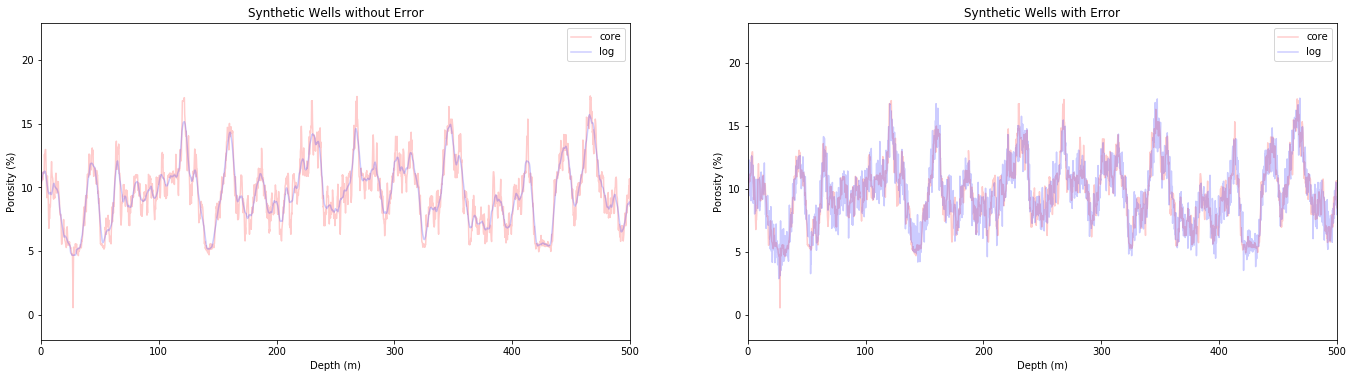


Results
No Error Variance:
Core: 8.58, Resid: 0.79, Log: 7.1 Cov: -0.35, Var Core Calc = 8.58.

Error Variance:
Core: 8.58, Resid: 1.8, Log: 8.11 Cov: 0.67, Var Core Calc = 8.58.

Variance Components: 
Error = 1.0
Change in Scale = 0.79

Variogram Analysis, Nugget Effect:
Core = 0.25, Log = 0.01, Log With Error = 1.01, Delta Nugget = 1.0


In [58]:
seed = 73074; np.random.seed(seed = seed); nbin = 50

core_mean = 10.0; core_std = 3.0; core_range = 15; log_error_std = 1.0          # 1D truth dataset parameters 

Xmin = 0; Xmax = 10000.0; Ymin = 0.0; Ymax = 0.0 

xsiz = ysiz = 0.25                                               # calculate the grid specifications
nx = int((Xmax-Xmin)/xsiz); ny = 1 #ny = int((Ymax-Ymin)/ysiz);
xmn = Xmin + xsiz * 0.5; ymn = Ymin + ysiz * 0.
xext = Xmax-Xmin; yext = Ymax-Ymin
                                                                 # well log data scale in meters
log_scale = 5.0

df_null = pd.DataFrame({'X':np.full(100,-999),'Y':np.full(100,-999),'Val':np.random.normal(loc=core_mean,scale=core_std,size=100)})

vmin = core_mean - 4 * core_std; vmax = core_mean + 4 * core_std

print('Numerical Model:')
print('Core: Mean = ' + str(core_mean) + ', St.Dev. = ' + str(core_std) + ', Range = ' + str(core_range))
print('Log: Scale = ' + str(log_scale) + ', Error St.Dev. = ' + str(log_error_std))
    
ndmin = 0; ndmax = 10; nodmax = 10; mults = 1; nmult = 2; noct = -1; radius = 1000; sang1 = 0 # simulation parameters
tmin = -99999.9; tmax = 99999.9
seed = 73073
iref = 0; cref = 2
ktype = 0; corr = 0.0
sec_map = None; df_ref = None

vario_core = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=core_range,hmin1=core_range) # porosity variogram

core = sgsim(1,df_null,'X','Y','Val',vmin,vmax,iref,df_ref,cref,
          nx,xmn,xsiz,ny,ymn,ysiz,seed,vario_core,ktype,corr,
          sec_map,'sim_temp.out')

df = scale_model(core,log_scale,log_error_std)
        
plot_models(df)
 
output_summary(df)

calc_nugget(df)

#### Impact of Well Log Scale 

Let's calculate the residual components and proportion of variance over a wide range of well log scales.

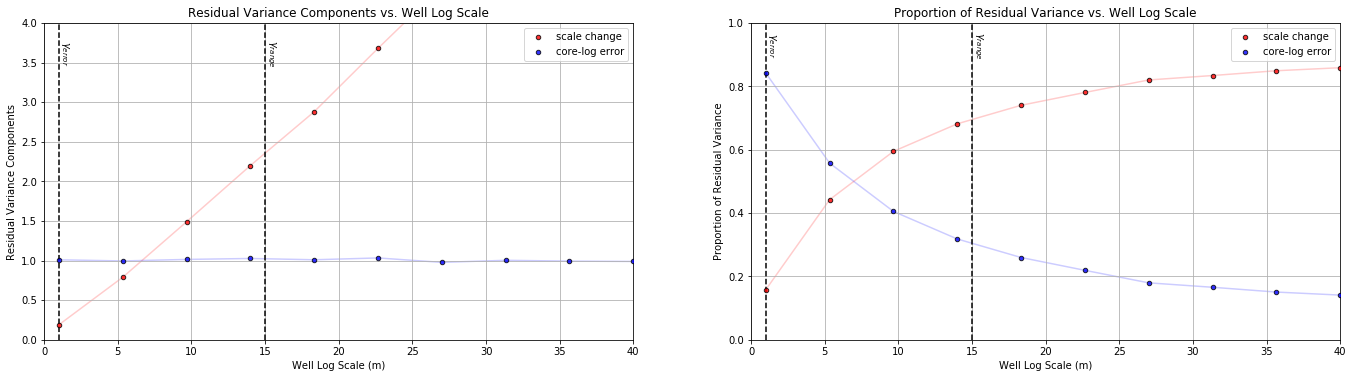

In [59]:
nruns = 10; max_scale = 40
log_scales = np.zeros(nruns); perrors = np.zeros(nruns); pscales = np.zeros(nruns)
errors = np.zeros(nruns); scales = np.zeros(nruns)
for i, log_scale in enumerate(np.linspace(1,max_scale,nruns)):
    df = scale_model(core, log_scale, log_error_std)
    pscales[i], perrors[i], scales[i], errors[i] = variance_proportions(df)
    log_scales[i] = log_scale

plt.subplot(121)
plt.plot(log_scales, scales,color = 'red',alpha=0.2,zorder=1)
plt.plot(log_scales, errors,color = 'blue',alpha=0.2,zorder=1)
plt.scatter(log_scales, scales,color = 'red',edgecolor='black',alpha=0.8,s=20,label = 'scale change',zorder=10)
plt.scatter(log_scales, errors,color = 'blue',edgecolor='black',alpha=0.8,s=20,label = 'core-log error',zorder=10)
plt.plot([1,1],[0,4.0],linestyle='--',color='black')
plt.annotate('$\gamma_{error}$',[1,3.5],rotation=270)
plt.plot([core_range,core_range],[0,4],linestyle='--',color='black')
plt.annotate('$\gamma_{range}$',[core_range,3.5],rotation=270)
plt.xlim([0,max_scale]); plt.ylim([0,4])
plt.xlabel('Well Log Scale (m)'); plt.ylabel('Residual Variance Components'); plt.title('Residual Variance Components vs. Well Log Scale')
plt.legend(loc = 'upper right')
plt.grid()

plt.subplot(122)
plt.plot(log_scales, pscales,color = 'red',alpha=0.2,zorder=1)
plt.plot(log_scales, perrors,color = 'blue',alpha=0.2,zorder=1)
plt.scatter(log_scales, pscales,color = 'red',edgecolor='black',alpha=0.8,s=20,label = 'scale change',zorder=10)
plt.scatter(log_scales, perrors,color = 'blue',edgecolor='black',alpha=0.8,s=20,label = 'core-log error',zorder=10)
plt.plot([1,1],[0,1.0],linestyle='--',color='black')
plt.annotate('$\gamma_{error}$',[1,0.9],rotation=270)
plt.plot([core_range,core_range],[0,1.0],linestyle='--',color='black')
plt.annotate('$\gamma_{range}$',[core_range,0.9],rotation=270)
plt.xlim([0,max_scale]); plt.ylim([0,1])
plt.xlabel('Well Log Scale (m)'); plt.ylabel('Proportion of Residual Variance'); plt.title('Proportion of Residual Variance vs. Well Log Scale')
plt.legend(loc = 'upper right')
plt.grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()   

Now we will expand on the step by step procedure of our workflow with figures to simulate using it on real data. We start by randomly retaining 500 samples of the core data.  

In [60]:
np.random.seed(9999)
idx = np.sort(np.random.randint(low=0, high=df.shape[0], size=500))
print('# of random Indexes to retain: {}'.format(idx.shape))

# of random Indexes to retain: (500,)


Lets visualize the data we retained.

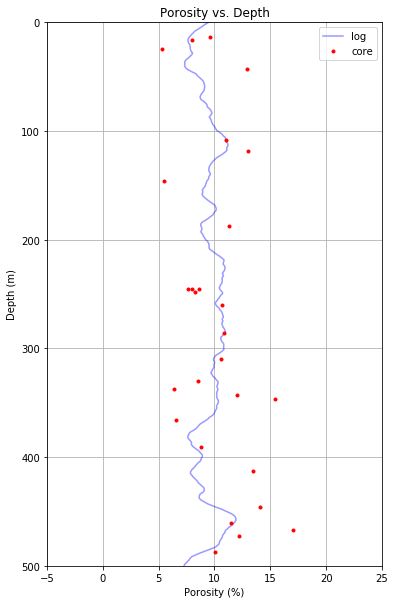

In [61]:
plt.figure().set_size_inches(6,10)
plt.plot(df['log'], df['X'], 'b-', label='log', alpha =0.4)
plt.plot(df.loc[idx,'core'], df.loc[idx,'X'], 'r.', label='core')
plt.legend(loc='upper right')
plt.xlabel('Porosity (%)'); plt.ylabel('Depth (m)'); plt.title('Porosity vs. Depth')
plt.xlim([-5,25]) 
plt.ylim([0,500])
plt.grid()
plt.gca().invert_yaxis()


plt.show();

Lets look at the exhaustive core datset, our core samples and log data.

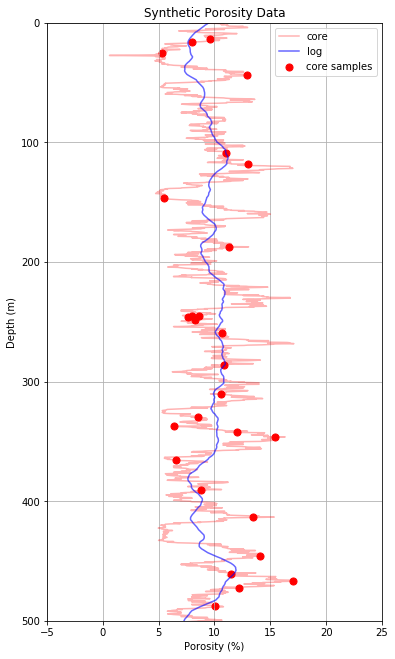

In [71]:
plt.figure().set_size_inches(6,11)
plt.plot(df['core'],df['X'],c='red',alpha=0.3,label='core')
plt.plot(df['log'],df['X'],c='blue',alpha=0.6,label='log')
plt.scatter(df_core1.core, df.loc[idx,'X'],s=50, label='core samples', color='red')
plt.legend(loc='upper right')
plt.xlabel('Porosity (%)'); plt.ylabel('Depth (m)'); plt.title('Synthetic Porosity Data')
plt.xlim([-5,25]) 
plt.ylim([0,500])
plt.grid()
plt.gca().invert_yaxis()


plt.show()



We save the new dataset as df_core1 to distinguish from the original and we viusalize the distributions of our core and log data and calculate the variance of each.

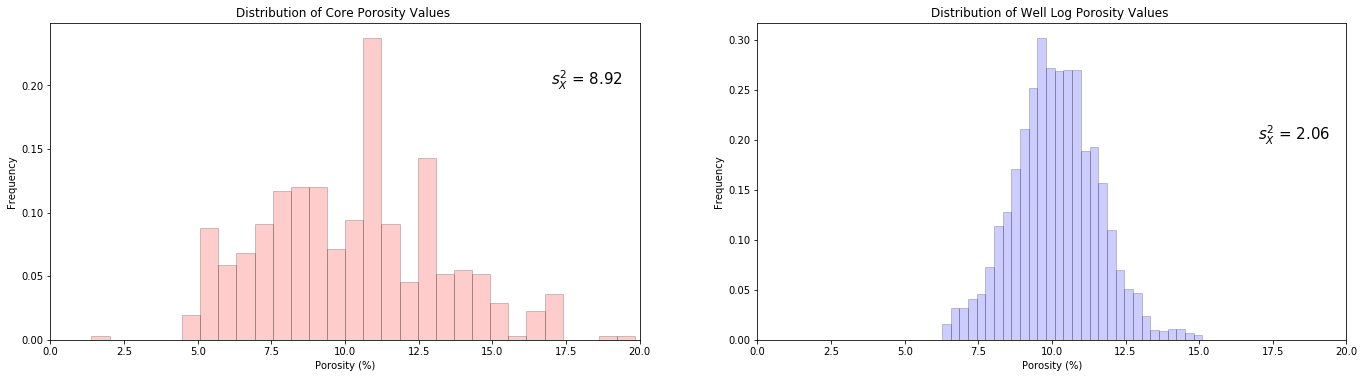

In [63]:
df_core1  = df.loc[idx]

plt.subplot(1,2,1)
plt.hist(x=df_core1['core'],weights=None,bins=30,alpha = 0.2,edgecolor='black',color='red',density = True)
plt.annotate('$s^2_X$ = ' + str(np.round(df_core1['core'].values.var(),2)),(17,0.20),fontsize = 15)
plt.xlabel('Porosity (%)'); plt.xlim([0,20])
plt.ylabel('Frequency'); 
plt.title('Distribution of Core Porosity Values ') 


plt.subplot(1,2,2)
plt.hist(x=df['log'],weights=None,bins=30,alpha = 0.2,edgecolor='black',color='blue',density = True)
plt.annotate('$s^2_X$ = ' + str(np.round(df['log'].values.var(),2)),(17,0.20),fontsize = 15)
plt.xlabel('Porosity (%)'); plt.xlim([0,20])
plt.ylabel('Frequency');
plt.title('Distribution of Well Log Porosity Values ') 



plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

Now that we have our data prepared we start with Step 1: Calculate the univariate and spatial statistics of $v$, including the mean, variance and variogram. We calculated the variance above of our core data to be 7.63. The remaining statistics can easily be found using .describe() 

In [64]:
df_core1.describe()

,X,core,log,res,log_err,res_err
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,4905.935000,10.221992,10.162186,-0.059806,10.176398,-0.045595
std,2875.550611,2.990196,1.444171,2.535691,1.780981,2.703045
min,13.500000,1.389527,6.374269,-6.574001,5.233269,-7.122583
25%,2665.562500,7.988524,9.305119,-1.812030,8.967061,-1.849030
50%,4697.375000,10.352608,10.144745,0.013707,10.116000,-0.041688
75%,7399.437500,12.212813,11.094346,1.701063,11.375980,1.814309
max,9997.500000,19.854216,14.665863,7.830680,15.446265,6.911911


### Variogram
We set our parameters for our experimental variogram and our semivariogram model and plot it. For calculating variograms with geostatspy see this workflow [Variogram Calculation](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/GeostatsPy_variogram_calculation.ipynb) and for variogram modeling see [Variogram Modeling](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/GeostatsPy_variogram_modeling.ipynb)

 make_variogram Warning: sill does not sum to 1.0, do not use in simulation 
 x,y,z offsets = 0.0,1.0


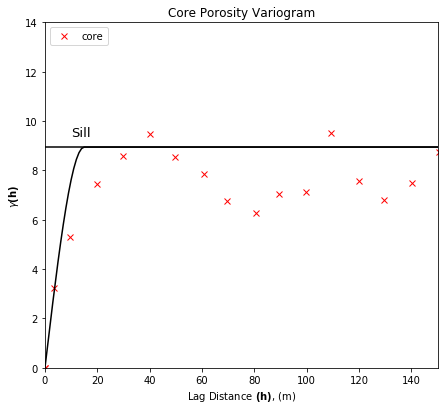

In [65]:
tmin = -9999.; tmax = 9999.; 
lag_dist = 10; lag_tol = 5; nlag = 100; bandh = 9999.9; azi = 0; atol = 0; isill = 0

lag, core_gamma, core_npair = geostats.gamv(df_core1,"X","X","core",tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)

nug = 0.0; nst = 1                                            
it1 = 1; cc1 = df_core1['core'].var(); azi1 = 0; hmaj1 = core_range; hmin1 = core_range
vario_core1 = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1) 

nlag = 150; xlag = 1; azm = 0;                                
index, h, gam, cov, ro = geostats.vmodel(nlag,xlag,azm,vario_core1)

plt.subplot(121)
plt.plot(lag,core_gamma,'x',color = 'red',label = 'core')
plt.plot(h,gam,color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Core Porosity Variogram')
plt.legend(loc='upper left')
plt.ylim([0,14])
plt.xlim([0,150])
plt.annotate('Sill',(10,9.4),fontsize = 13)
plt.plot([0,2000],[df_core1['core'].var(),df_core1['core'].var()],color = 'black')



plt.grid(False)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)


### F-Factor calculation
We calculate the variance reduction factor of scale up from core scale to log scale. Derivation and the behavior of the $f$ factor over different scale and spatial continuity data can be seen here. 

The $f$ factor is a measure of how much original data variance remains while upscaling the model cell or other volume support size. It is the ratio of the block scale, $V$, variance $D^2(V,\Omega)$ to the data volume support variance.  

\begin{equation}
f = \frac{D^2(V,\Omega)}{\sigma^2} 
\end{equation}

Using Krige's relation: 

\begin{equation}
D^2(v,\Omega) = D^2(v,V) + D^2(V,\Omega)
\end{equation}


We can substitute: $D^2(V,\Omega) = \sigma^2 - D^2(v,V)$, where $\sigma^2 = D^2(v,\Omega)$

\begin{equation}
f = \frac{\sigma^2-D^2(v,V)}{\sigma^2} 
\end{equation}

\begin{equation}
f = 1 - \frac{D^2(v,V)}{\sigma^2} 
\end{equation}

Simplifying further with $D^2(v,V) = \overline{\gamma(V,V)} - \overline{\gamma(v,v)} $, where $\overline{\gamma(v.v)} = 0$

\begin{equation}
f = 1 - \frac{\overline{\gamma(V,V}}{\sigma^2} 
\end{equation}

Now lets visualize how scale and spatial continuity effect the variance of a dataset. The following are examples taken from the [volume-variance demonstration](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/GeostatsPy_volume_variance.ipynb) and further investigated.



In [13]:
#We need the following functions from the volume variance demonstration linked above.

def getindex(nc,cmn,csiz,loc):
    ic = min(int((loc - cmn) / csiz), nc - 1)
    return ic

def upscale(model,new_nx,new_ny):
    ny, nx = model.shape
    new_xsiz = nx/new_nx; new_xmn = new_xsiz * 0.5
    new_ysiz = ny/new_ny; new_ymn = new_ysiz * 0.5
    new_model = np.zeros((new_ny,new_nx)); count = np.zeros((new_ny,new_nx))
    for iy in range(0,ny):
        yloc = iy+0.5
        new_iy = getindex(new_ny,new_ymn,new_ysiz,yloc)
        for ix in range(0,nx):
            xloc = ix+0.5
            new_ix = getindex(new_nx,new_xmn,new_xsiz,xloc)
            new_model[new_iy,new_ix] = new_model[new_iy,new_ix] + model[iy,ix] 
            count[new_iy,new_ix] = count[new_iy,new_ix] + 1 
    for iny in range(0,new_ny):
        for inx in range(0,new_nx):
            if count[iny,inx] > 0:
                new_model[iny,inx] = new_model[iny,inx] / count[iny,inx]
    return new_model

def cellplt_st(array,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    im = plt.imshow(array,cmap,vmin=vmin,vmax=vmax,extent=[xmin, xmax, ymin, ymax])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.clim(vmin,vmax)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20) 

In [14]:
#Set Spatial parameters
nx = 100; ny = 100; cell_size = 100                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                           # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size        # calculate the extent of model
cmap = plt.cm.inferno                                             # color map for plotting 
vmin = 0.0; vmax = 0.2                                            # property min and max


#Build 3 models with different ranges
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=1000,hmin1=500)
sim = GSLIB.sgsim_uncond(1,nx,ny,cell_size,seed = 73073, var = vario,output_file = "simulation")
sim = GSLIB.affine(sim,.1,0.03)                                     # correct the distribution to a target mean and standard deviation.

vario2 = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=100,hmin1=50)
sim2 = GSLIB.sgsim_uncond(1,nx,ny,cell_size,seed = 73073, var = vario2,output_file = "simulation")
sim2 = GSLIB.affine(sim2,.1,0.03)                                     # correct the distribution to a target mean and standard deviation.

vario3 = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=10000,hmin1=5000)
sim3 = GSLIB.sgsim_uncond(1,nx,ny,cell_size,seed = 73073, var = vario3,output_file = "simulation")
sim3 = GSLIB.affine(sim3,.1,0.03)                                     # correct the distribution to a target mean and standard deviation.


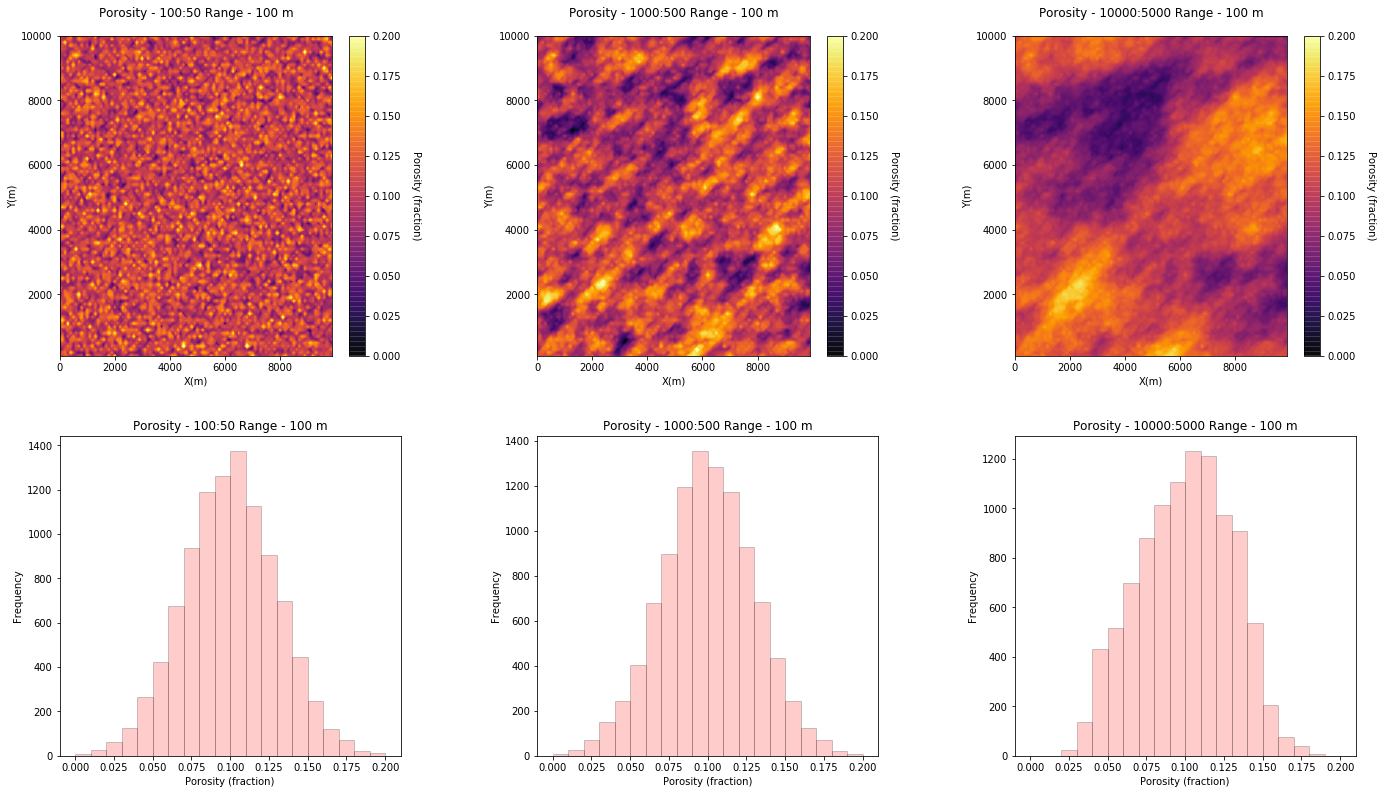

In [15]:
#Plotting of the subsurface property maps and distributions of each.

plt.subplot(231)
GSLIB.pixelplt_st(sim2,xmin,xmax,ymin,ymax,cell_size,0,.2,  "Porosity - 100:50 Range - 100 m","X(m)","Y(m)",'Porosity (fraction)',cmap)
#plt.rcParams.update({'font.size': 18})
#ax = plt.gca() #you first need to get the axis handle
#ax.set_aspect(1.25) #sets the height to width ratio to 1.5. 
plt.title("Porosity - 100:50 Range - 100 m", y=1.04)

plt.subplot(234)
GSLIB.hist_st(sim2.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 100:50 Range - 100 m")

plt.subplot(232)
GSLIB.pixelplt_st(sim,xmin,xmax,ymin,ymax,cell_size,0,.2,"Porosity - 1000:500 Range - 100 m","X(m)","Y(m)",'Porosity (fraction)',cmap)
#plt.rcParams.update({'font.size': 18})
#ax = plt.gca() #you first need to get the axis handle
#ax.set_aspect(1.25) #sets the height to width ratio to 1.5. 
plt.title("Porosity - 1000:500 Range - 100 m", y=1.04)

plt.subplot(235)
GSLIB.hist_st(sim.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 1000:500 Range - 100 m")

plt.subplot(233)
GSLIB.pixelplt_st(sim3,xmin,xmax,ymin,ymax,cell_size,0,.2,"Porosity - 10000:5000 Range - 100 m","X(m)","Y(m)",'Porosity (fraction)',cmap)
#plt.rcParams.update({'font.size': 18})
#ax = plt.gca() #you first need to get the axis handle
#ax.set_aspect(1.25) #sets the height to width ratio to 1.5. 
plt.title("Porosity - 10000:5000 Range - 100 m", y=1.04)

plt.subplot(236)
GSLIB.hist_st(sim3.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 10000:5000 Range - 100 m")


plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.5, wspace=0.4, hspace=0.25)



Now we scale up each dataset from 100 m to 500 and 1000 m.

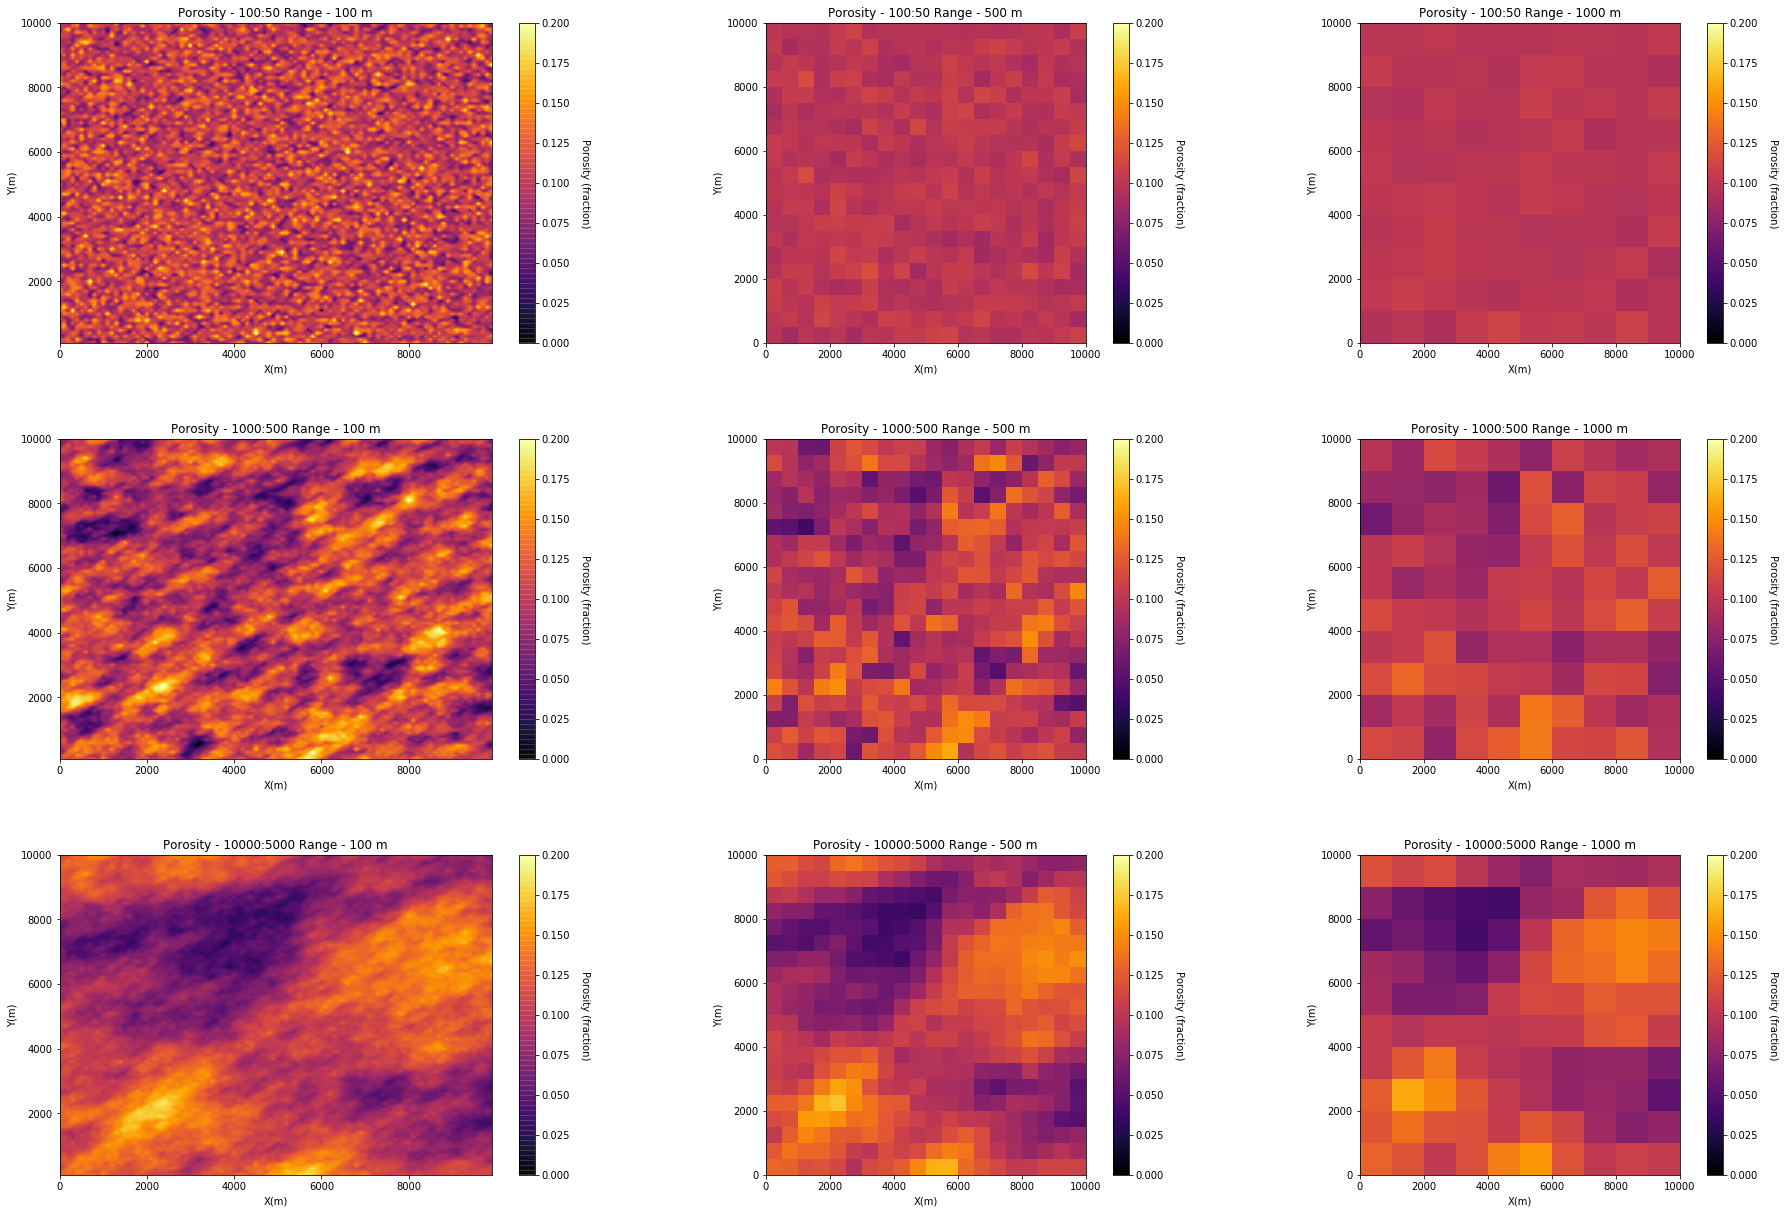

In [16]:
#Upscale to 500 m
midb = upscale(sim,new_nx = 20,new_ny = 20)
midb2 = upscale(sim2,new_nx = 20,new_ny = 20)
midb3 = upscale(sim3,new_nx = 20,new_ny = 20)

#Upscale to 1000 m
coarse = upscale(sim,new_nx = 10,new_ny = 10)
coarse2 = upscale(sim2,new_nx = 10,new_ny = 10)
coarse3 = upscale(sim3,new_nx = 10,new_ny = 10)

plt.subplot(331)
GSLIB.pixelplt_st(sim2,xmin,xmax,ymin,ymax,cell_size,0,.2,"Porosity - 100:50 Range - 100 m","X(m)","Y(m)",'Porosity (fraction)',cmap)

plt.subplot(332)
cellplt_st(midb2,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 100:50 Range - 500 m",'X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(333)
cellplt_st(coarse2,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 100:50 Range - 1000 m",'X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(334)
GSLIB.pixelplt_st(sim,xmin,xmax,ymin,ymax,cell_size,0,.2,"Porosity - 1000:500 Range - 100 m","X(m)","Y(m)",'Porosity (fraction)',cmap)

plt.subplot(335)
cellplt_st(midb,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 1000:500 Range - 500 m",'X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(336)
cellplt_st(coarse,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 1000:500 Range - 1000 m",'X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(337)
GSLIB.pixelplt_st(sim3,xmin,xmax,ymin,ymax,cell_size,0,.2,"Porosity - 10000:5000 Range - 100 m","X(m)","Y(m)",'Porosity (fraction)',cmap)

plt.subplot(338)
cellplt_st(midb3,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 10000:5000 Range - 500 m",'X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(339)
cellplt_st(coarse3,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 10000:5000 Range - 1000 m",'X(m)','Y(m)','Porosity (fraction)',cmap)


plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=4.0, wspace=0.1, hspace=0.3)
plt.show()

We observe that the larger spatial continuity dataset preserves the variance in the data with upscaling, while the smaller range results in a fast regression to the mean. Now lets visualize the distribution of porosity for the middle case over all three scales. 

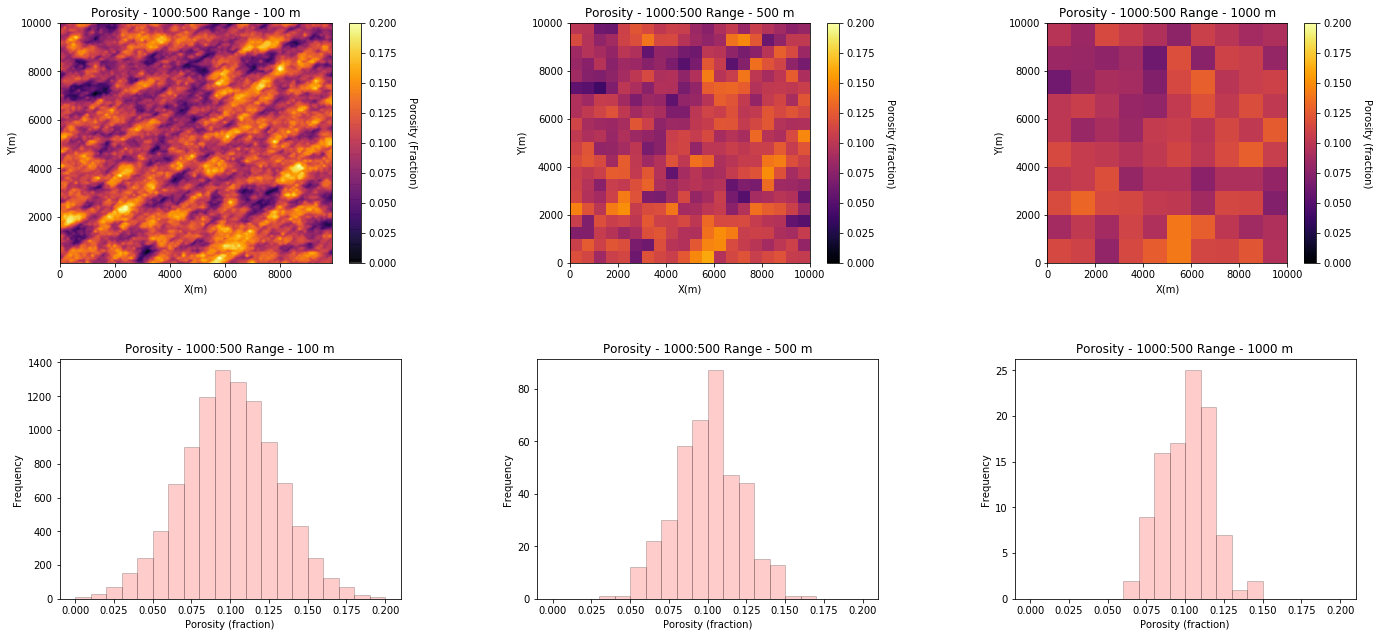

In [17]:
plt.subplot(231)
GSLIB.pixelplt_st(sim,xmin,xmax,ymin,ymax,cell_size,0,.2,"Porosity - 1000:500 Range - 100 m","X(m)","Y(m)","Porosity (Fraction)",cmap)

plt.subplot(234)
GSLIB.hist_st(sim.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 1000:500 Range - 100 m")

plt.subplot(232)
cellplt_st(midb,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 1000:500 Range - 500 m",'X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(235)
GSLIB.hist_st(midb.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 1000:500 Range - 500 m")

plt.subplot(233)
cellplt_st(coarse,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 1000:500 Range - 1000 m",'X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(236)
GSLIB.hist_st(coarse.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 1000:500 Range - 1000 m")

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.0, wspace=0.4, hspace=0.4)
plt.show()

And now for all of the cases.

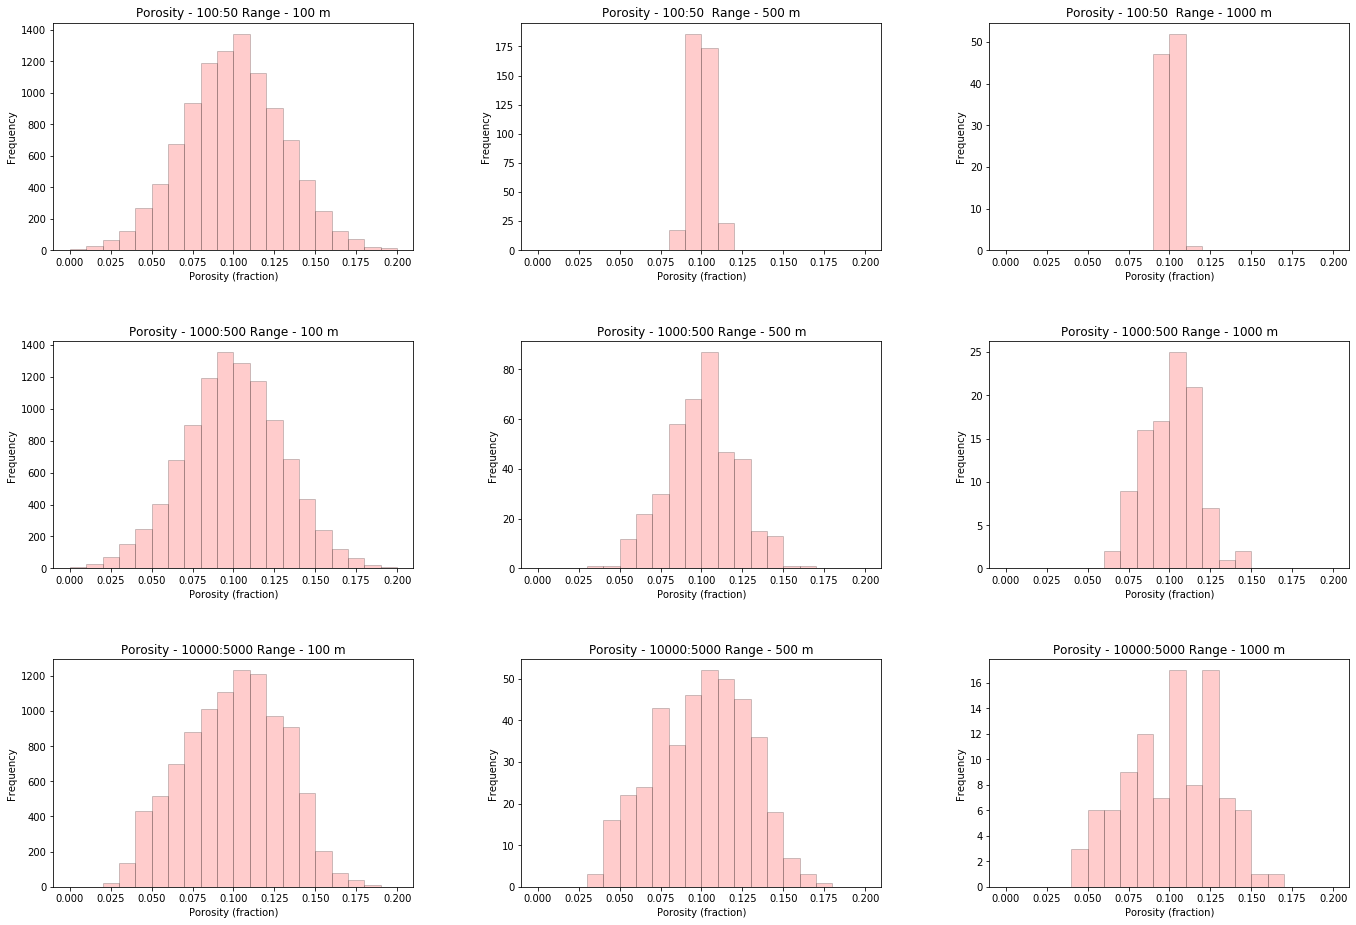

In [18]:
plt.subplot(331)
GSLIB.hist_st(sim2.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 100:50 Range - 100 m")

plt.subplot(332)
GSLIB.hist_st(midb2.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 100:50  Range - 500 m")

plt.subplot(333)
GSLIB.hist_st(coarse2.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 100:50  Range - 1000 m")

plt.subplot(334)
GSLIB.hist_st(sim.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 1000:500 Range - 100 m")

plt.subplot(335)
GSLIB.hist_st(midb.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 1000:500 Range - 500 m")

plt.subplot(336)
GSLIB.hist_st(coarse.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 1000:500 Range - 1000 m")

plt.subplot(337)
GSLIB.hist_st(sim3.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 10000:5000 Range - 100 m")

plt.subplot(338)
GSLIB.hist_st(midb3.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 10000:5000 Range - 500 m")

plt.subplot(339)
GSLIB.hist_st(coarse3.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 10000:5000 Range - 1000 m")

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.0, wspace=0.3, hspace=0.4)
plt.show()

Our initial observations hold true as we can see the variance of larger range data decreases little when moving up in scale. However, the 100:50 range dataset has a strong reduction even after the first upscaling. This reduction that we see can be calculated with the $f$ factor. We examine the effect by displaying the variance reduction due to scale up over a combinatorial of variogram range and scale.

In [19]:
#Start with initial model.
model = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0, hmaj1=10000,hmin1=5000)

#Set ranges to update model with
ranges_maj = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
ranges_min = [50, 50,  100, 150, 200, 250, 300, 350, 400, 500, 500,  600,  700,  800,  900,  1000, 2000, 3000, 4000, 5000]

#Set upscaled dimensions to loop through
new_coord = np.zeros((len(ranges_maj)))

for i in range(len(new_coord)):
    new_coord[0] = 10
    new_coord[i] = new_coord[i-1]*1.2
new_coord = new_coord.astype(int)

print('Ranges Major: {} | Ranges Minor: {} | New Coord: {}'.format(len(ranges_maj), len(ranges_min), len(new_coord)))
    

Ranges Major: 20 | Ranges Minor: 20 | New Coord: 20


Simulations shape: (20, 10000)
Var shape: (20, 20)


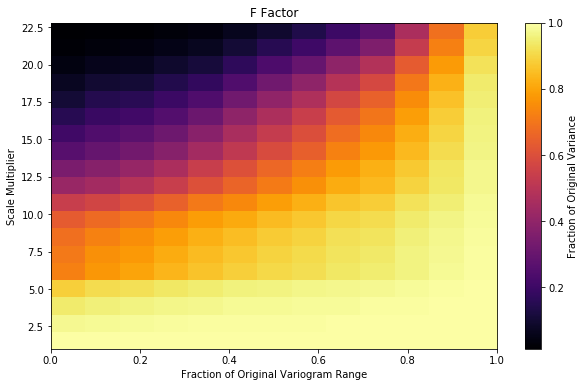

In [20]:
sim = np.zeros((len(ranges_maj),100,100))
simulations = np.zeros((len(ranges_maj),100,100))
var = np.zeros((len(ranges_maj),len(new_coord)))

#Create models for all ranges
for i,j in zip(range(len(ranges_maj)),range(len(ranges_min))):
    model[i] = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=ranges_maj[i], hmin1=ranges_min[j])
    sim[i,:,:] = GSLIB.sgsim_uncond(1,nx,ny,cell_size,seed = 73073, var = model[i], output_file = "simulation")
    simulations[i,:,:] = GSLIB.affine(sim[i,:,:], .1, 0.03)
simulations = np.reshape(simulations, (20,10000))
print('Simulations shape:', simulations.shape)

#Upscale and calculate variance.
for i in range(len(ranges_maj)):
    for j in range(len(new_coord)):
        var[i,j] = stats.variance(upscale(simulations[i].reshape(100,100), new_nx=new_coord[j], new_ny=new_coord[j]).flatten())
print('Var shape:', var.shape)

#Calculate f-factor
temp = var[:,:-7]
for i in np.arange(1,20):
    temp[i,:] = var[i,:-7]/var[-1,:-7]
    
    
plt.figure(figsize=(10,6))
plt.imshow(temp[1:,:], aspect='auto', cmap='inferno', extent=[0,1,1,22.8])
plt.xlabel('Fraction of Original Variogram Range'); plt.ylabel('Scale Multiplier')
plt.colorbar(label='Fraction of Original Variance')
plt.title("F Factor")
plt.show();

This is a nice demonstration of how the $f$ factor behaves. The spatial continuity range increases along the x-axis and the cell size increases along the y-axis. This matches our observation that we saw above. 

Lets calculate the $f$ factor for our core samples. If the $f$ factor is not significantly different from 1 (e.g. greater than 0.99), then we assume scale change does not have a significant impact and we assume the residual variance is the variance due to random measurement error. $ \sigma_{x_r}^2 = \sigma_{x_r,error}^2 $. (We solve for this analytically since we have exhaustive core dataset)

In [66]:
up_core = df['core'].var()
point_core = df_core1['core'].var()
f = up_core/point_core
print("F factor for the core data is: " + str(f))

F factor for the core data is: 0.9593685775456641


As our f-factor is less than 1, we assume scale change does have an impact and we proceed to calculate the $v$ to $V$ residual and residual variance.

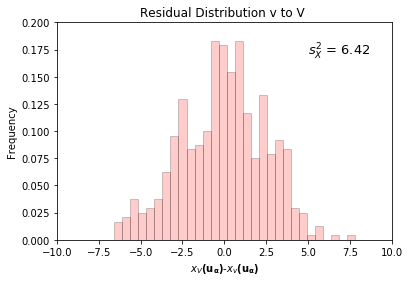

In [67]:
plt.hist(x=df_core1['res'],weights=None,bins=30,alpha = 0.2,edgecolor='black',color='red',density = True)
plt.annotate('$s^2_X$ = ' + str(np.round(df_core1['res'].values.var(),2)),(5,0.17),fontsize = 13)
plt.xlabel(r'$x_V \bf(u_α)$' '-' r'$x_v \bf(u_α )$')
plt.ylabel('Frequency'); 
plt.ylim([0,0.2]); plt.xlim([-10,10])
plt.title('Residual Distribution v to V ') 
plt.show()

Then with the univariate and spatial statistics of core samples($v$) calculated above, calculate realizations of $v$, $v^l$, and scale up to the support size of $V$ dataset and calculate the variance due to change in scale, from the residuals of $V$ and $V^*$, scaled up from the realization of $v$.

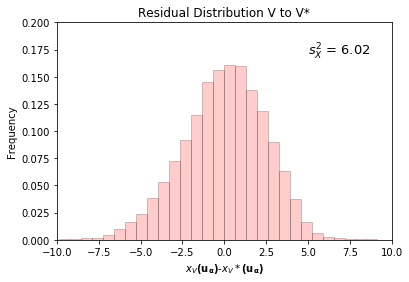

In [68]:
plt.hist(x=df['res'],weights=None,bins=30,alpha = 0.2,edgecolor='black',color='red',density = True, label='dist1')
plt.annotate('$s^2_X$ = ' + str(np.round(df['res'].var(),2)),(5.0,0.17),fontsize = 13)
plt.xlabel(r'$x_V \bf(u_α)$' '-' r'$x_V* \bf(u_α )$')

plt.ylabel('Frequency'); plt.ylim([0,0.2]); plt.xlim([-10,10])
plt.title('Residual Distribution V to V*') 
plt.show()

We have now calculated our two variance componenets, the residual variance, $\sigma_{x_r}^2$ and variance due to scale change, $\sigma_{x_r,scale}^2$. Assuming independence between them and applying the additivity of variance we calculate our variance due to random measurement error.

In [69]:
error = df_core1['res'].var() - df['res'].var()
print("Variance due to random measurment error: " +str(np.round(error,2)))

Variance due to random measurment error: 0.41


Now we can rescale the residual distribution ($v$ to $V$) to match the target variance, the variance due to random measurement error. we do this with the affine correction.

### Affine Correction

The affine distribution correction is a general distribution transformation that assumes no shape change. For our problem, the affine equation is updated as:

\begin{equation}
x_r' = \sqrt{ \frac{\sigma_{x_r,error}^2} {\sigma_{x_r}^2} } * (x_r - \overline{x_r}) + \overline{x_r'}
\end{equation}

$x_r$ is the original value of our residual distribution and $x_r'$ is the new value with the corrected variance. 

$\overline{x_r}$ is the mean of the original residual distribution which equals $\overline{x_r'}$ as the means for both are 0.

A limitation of this type of correction can potentially result in arbitrary minimum and maximum resulting in unrealistic values.

Lets rescale our distribution.

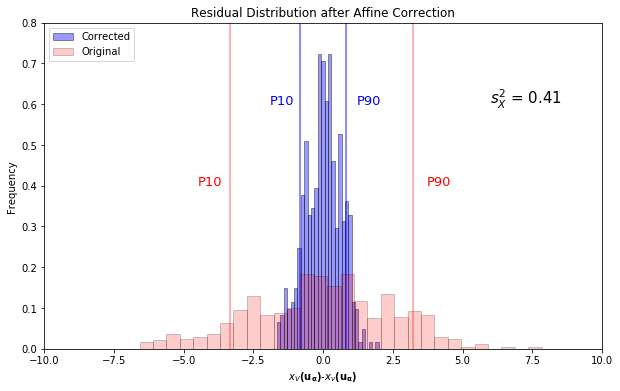

In [70]:
affine = (math.sqrt(error/df_core1['res'].var())*(df_core1['res'] -df_core1['res'].mean()))+0

plt.figure(figsize=(10,6))

plt.hist(x=affine,weights=None,bins=30,alpha = 0.4,edgecolor='black',color='blue',density = True, label='Corrected')
plt.hist(x=df_core1['res'].values,weights=None,bins=30,alpha = 0.2,edgecolor='black',color='red',density = True, label='Original')
plt.annotate('$s^2_X$ = ' + str(np.round(affine.var(),2)),(6,0.6),fontsize = 15)
plt.xlabel(r'$x_V \bf(u_α)$' '-' r'$x_v \bf(u_α )$')

plt.ylabel('Frequency'); plt.xlim([-10,10]); plt.ylim([0,0.8])
plt.title('Residual Distribution after Affine Correction') 
plt.legend(loc='upper left')

plt.vlines(np.percentile(df_core1['res'].values, 10), 0, 0.8, color='red', alpha=0.4)
plt.vlines(np.percentile(df_core1['res'].values, 90), 0, 0.8,color='red', alpha=0.4)
plt.annotate('P10',(-4.5,0.4),fontsize = 13, color='red')
plt.annotate('P90',(3.7,0.4),fontsize = 13, color='red')


plt.vlines(np.percentile(affine.values, 10), 0, 0.8,color='blue',alpha=0.6)
plt.vlines(np.percentile(affine.values, 90), 0, 0.8,color='blue',alpha=0.6)
plt.annotate('P10',(-1.9,0.6),fontsize = 13, color='blue')
plt.annotate('P90',(1.2,0.6),fontsize = 13, color='blue')

plt.show()

#### Comments

After completing the affine correction, it is evident that if we did not account for the change in scale between the two datasets, this would lead us to greatly overestimate the uncertainty. 

This workflow demonstrated the importance of accounting for scale and spatial continuity of multiple datasets when modeling uncertainty. Through the implementation of this workflow, we can more accurately quantify uncertainty resulting in improved decision making when constructing spatial models.

* We demonstrated the concept of dispersion variance and its application as well as using dispersion variance to calculate the variance reduction factor
* We demonstrated the application of statistical methods such as the semivariogram and the additivty of variance. 

  
#### The Authors:

### Blazej Ksiazek, Graduate Research Assistant, University of Texas at Austin 

[Github] (to be linked) [LinkedIn] (to be linked)

Blazej is currently pursuing an M.S in Petroleum Engineering at the University of Texas at Austin in the Hildebrand Department of Petroleum and Geosystems Engineering. He graduated with his B.S. in Petroleum Engineering and a minor in Spanish from the University of Tulsa in May 2021. Blazej has an interest in spatial data analytics, machine learning and uncertainty modeling. He is also a member of the University of Texas at Austin Petrobowl Team.    

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  
  